# Lesson2 畳み込みニューラルネットワーク (CNN)

## 目次

- Section1 解説
  - 1.1 CNN基礎
  - 1.2 Convolution(畳み込み)層
  - 1.3 Pooling(プーリング)層
  - 1.4 確認問題
- Section2 実装①
  - 2.1 Fasion MNISTをCNNでクラス分類
  - 2.2 CIFAR10のデータをCNNでクラス分類
- Section3 テクニック・発展内容
  - 3.1 Data Augmentation
  - 3.2 画像データの正規化
  - 3.3 Batch Normalization
  - 3.4 Skip Connection  (Residual Network)
  - 3.5 学習済みネットワークの利用
  - 3.6 学習させたモデルの保存・再利用
  - 3.7 確認問題
- Section4 実装②
  - 4.1 CIFAR10のデータをCNNでクラス分類②
- Section5 ケーススタディ

In [1]:
%matplotlib inline

import os

import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, Add, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

random_state = 42

## Section3 テクニック・発展内容

### 3.1. Data Augmentation

CNNはpoolingにより細かいズレがあっても特徴を獲得することができますが、大きなズレや回転、反転などに対しては同じ特徴と認識することができません.。
学習データに人工的にさまざまな変換を加えデータを増やすことで、擬似的にこの問題の解決を試みます。

2014の画像分類のコンペで優勝したGoogleNetではこれにより144倍にデータを拡張しています.
単純な手法ですが精度向上に大きく貢献するので、積極的に使いましょう。

下図にデータ拡張の例を示します。

<img src="./figures/data_aug.png" width="500">

出典: Custom Image Augmentation(https://towardsdatascience.com/image-augmentation-14a0aafd0498)

ただし画像を変換するときにその画像のクラスが変わらないように注意します。
例えば下図の例のように数字の`6`のデータを水増ししたいときに上下反転させてしまうと`9`になってしまいます。
これでは間違った教師データを生成していることになってしまうので **だめ** です。

<img src="./figures/data_aug_wrong.png" width="500">

kerasの実装においては`keras.preprocessing.image`を使います。

ここではSection2で利用したCIFAR10のデータを例に変換例を見ていきましょう。

#### 3.1.1 オリジナル

まずは、これから変換する画像を表示します。

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
y_train = np.eye(10)[y_train.astype('int32').flatten()]

x_test = x_test.astype('float32') / 255
y_test = np.eye(10)[y_test.astype('int32').flatten()]

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=10000)

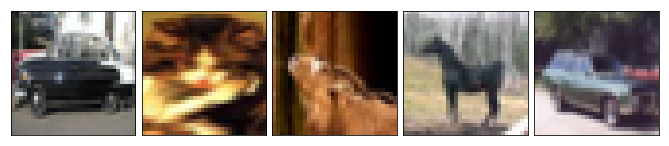

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i])

#### 3.1.2 左右にずらす

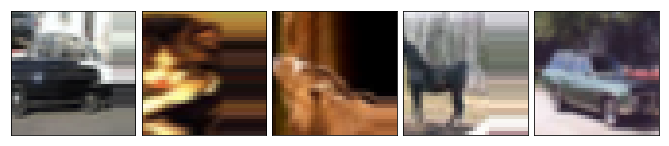

In [4]:
datagen = ImageDataGenerator(width_shift_range=0.4)

datagen.fit(x_train)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9, shuffle=False):
    for i in range(5):
        ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(x_batch[i])
    break

#### 3.1.3 上下にずらす

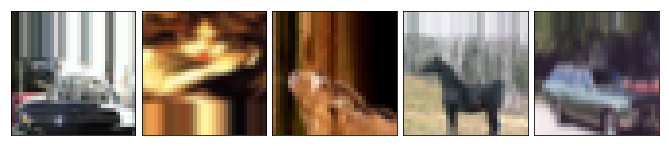

In [5]:
datagen = ImageDataGenerator(height_shift_range=0.4)

datagen.fit(x_train)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9, shuffle=False):
    for i in range(5):
        ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(x_batch[i])
    break

#### 3.1.4 左右反転

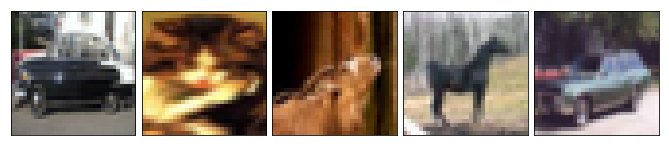

In [6]:
datagen = ImageDataGenerator(horizontal_flip=True)

datagen.fit(x_train)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9, shuffle=False):
    for i in range(5):
        ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(x_batch[i])
    break

#### 3.1.5 回転

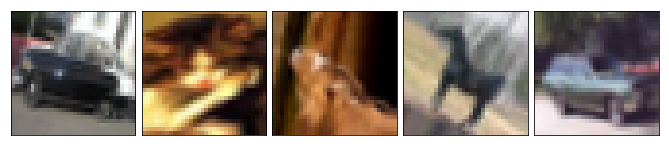

In [7]:
datagen = ImageDataGenerator(rotation_range=30)

datagen.fit(x_train)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9, shuffle=False):
    for i in range(5):
        ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(x_batch[i])
    break

その他にも色々あるので詳細は公式のドキュメントを参照してください。

Keras ImageDataGenerator: https://keras.io/preprocessing/image/

### 3.2 画像データの正規化

実際の画像データはノイズなどがあり画像間やピクセル間によって入力の値の分布が異なります。これを正規化することで入力層において特徴を抽出しやすくします。

kerasでの実装には`ImageDataGenerator`を使います。

#### 3.2.1 Global Contrast Normalization (GCN)

画像ごとにピクセルの値を平均0、分散1に正規化します。

$$
    x^{norm} = \frac{x - \mu}{\sqrt{\sigma}}
$$

In [8]:
# 可視化用に値のrangeを[0, 1]に修正
def normalize(x):
    max_x = np.max(x, axis=(0, 1), keepdims=True)
    min_x = np.min(x, axis=(0, 1), keepdims=True)
    return (x - min_x) / (max_x - min_x)

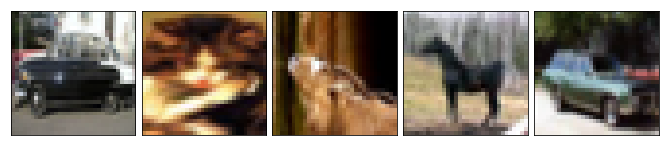

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gcn_whitening = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

gcn_whitening.fit(x_train)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for x_batch, y_batch in gcn_whitening.flow(x_train, y_train, batch_size=9, shuffle=False):
    for i in range(5):
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        ax.imshow(normalize(x_batch[i]))
    break

#### 3.2.2 Zero-phase Component Analysis (ZCA) Whitening

入力の各要素間の相関をゼロ(白色化)にします。

PCAを利用して共分散行列を単位行列化 (分散1、共分散0) したのち、元の空間に戻します。


$$
    x^{ZCA} = A\Lambda^{-\frac{1}{2}}\Lambda^{T}(x - \mu)
$$

/usr/local/var/pyenv/versions/3.6.0/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


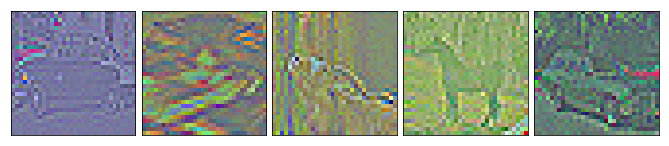

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

zca_whitening = ImageDataGenerator(zca_whitening=True)

zca_whitening.fit(x_train)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for x_batch, y_batch in zca_whitening.flow(x_train, y_train, batch_size=9, shuffle=False):
    for i in range(5):
        ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(normalize(x_batch[i]))
    break

### 3.3 Batch Normalization

入力画像に対して正規化をおこなったように、各隠れ層の入力の分布も安定させたいと考えます。
これがない場合、深層のネットワークにおいては層を重ねるほど分布が不安定になります。
特に深層学習において、学習データと検証(評価)データ間で各層の分布が変わってしまう現象は **内部共変量シフト** と呼ばれます.

**Batch Normalization** では各層の出力を正規化することでこの問題の解決を試みます。

ある層への入力を$X\in\mathcal{R}^{H\times W\times C\times N}$(H:縦の次元数、W:横の次元数、C:チャンネル数、N:バッチサイズ)とすると、それぞれのチャンネルに対して平均・分散$\mu$、$\sigma^2\in\mathcal{R}^{H\times W\times C}$を計算し、正規化を行います。
$$
    \hat{X} = \frac{X - \mu}{\sigma}
$$
その後、平均・分散を調整する学習パラメータ$\gamma、\beta\in\mathcal{R}^{H\times W\times C}$を用いて出力を計算します。
$$
    Y = \gamma \hat{X} + \beta
$$

これにより、各層の出力の分布を安定させることができます。

$\star$ 後続の研究で、Batch Normalizationは内部共変量シフトを軽減させる効果は実はほとんどないことが実験的に示されています。
一方でBatch Normalizationにより損失関数・勾配の形状が緩やかになり、勾配法などによる最適化が容易になることが実験的に・一部理論的に示されています。

出典: S. Santurkar et al. "How Does Batch Normalization Help Optimization? (No, It Is Not About Internal Covariate Shift)". arXiv. 2018

Kerasでは層として`BatchNormalizatoin`が用意されているので、畳み込み層やプーリング層と同じようにレイヤとして追加するだけです。

```python
from keras.layers.normalization import BatchNormalization

...
model.add(BatchNormalization())
...

```

### 3.4 Skip Connection (Residual Network)

Skip Connection (Residual Network) は、層を飛び越えた結合をつくることで勾配消失問題を解消しようとする手法です。

アイデアはシンプルで、次の図ようになります。

<img src="./figures/resblock.png">

K. He et al., "Deep Residual Learning for Image Recognition", CVPR, 2015

上の図のように重みを掛けずに値を渡し、逆伝播の際に出力層側から誤差をそのまま入力層側に伝えることで、勾配が消失しにくいネットワーク構造をつくっていると考えることができます。

`Keras`ではFunctional APIを利用することで実装できます. 以下実装例です.

```python
def resblock(x, filters=64, kernel_size=(3, 3)):
    x_ = Conv2D(filters, kernel_size, padding='same')(x)
    x_ = BatchNormalization()(x_)
    x_ = Conv2D(filters, kernel_size, padding='same')(x_)
    x = Add()([x_, x])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

from keras import backend as K

inputs = Input(shape=(32, 32, 3))

x = Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu')(inputs)
x = resblock(x)
x = resblock(x)
x = Flatten()(x)
y = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=y)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=3, verbose=1)
```

### 3.5 学習済みネットワークの利用

前述の通り、畳み込みニューラルネットワークの入力層付近では局所的な特徴 (エッジなど) を抽出しています。これらの特徴は多くの画像データに共通しています。

このことを利用し、あらかじめ別の大規模なデータセットで十分に学習されたネットワークの出力層以外の重みを初期値として活用することを考えます。

`Keras`では事前に大規模なデータセット (ImageNet) に対して学習されたモデルがロードできるようになっています。

```python
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')
weights = [com.get_weights() for com in model.layers[1:]]
```

```python
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3))) # 32x32x3 -> 30x30x64
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) # 30x30x64 -> 28x28x64
model.add(MaxPooling2D(pool_size=(2, 2))) # 28x28x64 -> 14x14x64

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) # 14x14x64 -> 12x12x128
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) # 12x12x128 -> 10x10x128
model.add(MaxPooling2D(pool_size=(2, 2))) # 10x10x128 -> 5x5x128

model.add(Flatten())
model.add(Dense(10, activation='softmax'))
```

上記のようにモデルを構築したのち、ロードした重みを各層に設定します。

```python
# weightの初期化
model.layers[0].set_weights(weights[0])
model.layers[1].set_weights(weights[1])
model.layers[3].set_weights(weights[3])
model.layers[4].set_weights(weights[4])
```

### 3.6 学習させたモデルの保存・再利用

#### 3.6.1 保存

学習させたモデルは`hdf5`形式で保存することができます。

```python
model.save('./mnist_cnn.h5')
```

#### 3.6.2 再利用

保存されたモデルは以下のようにロードして再利用することができます。

```python
from tensorflow.keras.models import load_model

model = load_model('./mnist_cnn.h5')

y_pred = model.predict(x_valid)
```

### 3.7 確認問題

問1. **Global Contrast Normalization** に関する説明として正しいものを選択肢から一つ選びなさい。

    ① データセット全体でそれぞれのピクセルの平均を0、分散を1正規化する手法。
    ② 画像ごとにピクセル間の平均を0、分散を1正規化する手法。
    ③ ミニバッチごとにそれぞれのピクセルの平均を0、分散を1に正規化する手法。
    ④ 評価用データに対してのみ画像ごとにピクセル間の平均を0、分散を1正規化する手法。

問2. **Batch Normalization** に関する説明として正しいものを選択肢から一つ選びなさい。

    ① 各層への入力の分布を安定させるためにバッチ方向に対して正規化を行う。
    ② 各層への入力の分布を安定させるためにバッチの各サンプル内で正規化を行う。
    ③ 各層への入力の分布を安定させるために特徴マップ方向に対して正規化を行う。
    ④ ミニバッチ内のクラスの分布を正規化する。

問3. **Skip Connection** に関する説明として正しいものを選択肢から１つ選びなさい。

    ① 層を飛び越えた結合をつくることにより、出力層側からの勾配を伝えやすくする。
    ② 層を飛び越えた結合をつくることにより、出力層側からの勾配を軽減させる。
    ③ 一定の確率でランダムに層を飛び越えて順・逆伝播を行うことにより、出力層側からの勾配を伝えやすくする。
    ④ 一定の確率でランダムに層を飛び越えて順・逆伝播を行うことにより、出力層側からの勾配を軽減させる。

問4. **学習済みモデルの利用** に関する説明として正しいものを選択肢から一つ選びなさい。

    ① CNNの入力層付近ではエッジなどの局所的な特徴を獲得しているので、学習済みの重みを転移させて使うことにより精度の向上が期待できる。
    ② CNNの出力層付近では自動車などの大局的な特徴を獲得しているので、学習済みの重みを転移させて使うことにより精度の向上が期待できる。
    ③ CNNの入力層付近では自動車などの大局的な特徴を獲得しているので、学習済みの重みを転移させて使うことにより精度の向上が期待できる。
    ④ CNNの出力層付近ではエッジなどの局所的な特徴を獲得しているので、学習済みの重みを転移させて使うことにより精度の向上が期待できる。

### 参考資料

いくつか参考となると思われる文献を挙げます。(★: おすすめ)

1. ★I. Goodfellow et al. "Deep Learning", 2016, MIT Press \[[オンライン版(無料)](http://www.deeplearningbook.org/)\], \[[amazon(原著)](https://www.amazon.co.jp/Deep-Learning-Adaptive-Computation-Machine/dp/0262035618)\], \[[amazon(訳本)](https://www.amazon.co.jp/%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92-Ian-Goodfellow/dp/4048930621)\]
    - Chapter 9.にCNNの考え方について記述があります。数式は少なく、直感的な理解を優先して書かれている印象です。丁寧に書かれているため、とてもわかりやすいです。
2. 原田達也, "画像認識", 2017, 講談社 \[[amazon](https://www.amazon.co.jp/%E7%94%BB%E5%83%8F%E8%AA%8D%E8%AD%98-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%83%95%E3%82%A7%E3%83%83%E3%82%B7%E3%83%A7%E3%83%8A%E3%83%AB%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E5%8E%9F%E7%94%B0-%E9%81%94%E4%B9%9F/dp/4061529129)\]
    - Chapter 6.にCNNについての記述があります。CNNの考え方、順伝播・逆伝播の計算方法について簡潔にまとめられています。深層学習に限らない画像認識の手法について記述されています。
3. 瀧雅人, "これならわかる深層学習入門", 2017, 講談社 \[[amazon](https://www.amazon.co.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%82%B9%E3%82%BF%E3%83%BC%E3%83%88%E3%82%A2%E3%83%83%E3%83%97%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E3%81%93%E3%82%8C%E3%81%AA%E3%82%89%E3%82%8F%E3%81%8B%E3%82%8B%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E5%85%A5%E9%96%80-KS%E6%83%85%E5%A0%B1%E7%A7%91%E5%AD%A6%E5%B0%82%E9%96%80%E6%9B%B8-%E7%80%A7-%E9%9B%85%E4%BA%BA/dp/4061538284)\]
    - Chapter 8.にCNNについての詳細な説明があります。CNNの背景・考え方から、順伝播・逆伝播の計算方法について丁寧に記述されています。